In [46]:

# ============================================================
# 1. INSTALL & IMPORT LIBRARIES
# ============================================================
!pip install shap -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, f1_score, precision_score,
                             recall_score, roc_auc_score, roc_curve)
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                               HistGradientBoostingClassifier, VotingClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import (SelectKBest, chi2, RFE,
                                        mutual_info_classif, SelectFromModel)
from sklearn.utils import resample

print('All libraries imported successfully ✅')

All libraries imported successfully ✅


In [47]:
# ============================================================
# 2. LOAD & PARSE ARFF
# ============================================================
def load_ckd_arff(filepath):
    col_names = ['age','bp','sg','al','su','rbc','pc','pcc','ba','bgr','bu','sc',
                 'sod','pot','hemo','pcv','wbcc','rbcc','htn','dm','cad',
                 'appet','pe','ane','class']
    rows = []
    in_data = False
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if line.lower() == '@data':
                in_data = True
                continue
            if in_data and line and not line.startswith('%'):
                parts = [p.strip() for p in line.split(',')]
                if len(parts) == 25:
                    rows.append(parts)
    df = pd.DataFrame(rows, columns=col_names)
    df = df.replace('?', np.nan)
    return df

df = load_ckd_arff('chronic_kidney_disease.arff')

print('=' * 60)
print('UCI CKD DATASET OVERVIEW')
print('=' * 60)
print(f'Shape            : {df.shape}')
print(f'CKD cases        : {(df["class"]=="ckd").sum()}')
print(f'Non-CKD cases    : {(df["class"]=="notckd").sum()}')
print(f'Total missing    : {df.isnull().sum().sum()}')
print(f'\nMissing per feature:')
print(df.isnull().sum()[df.isnull().sum()>0])

UCI CKD DATASET OVERVIEW
Shape            : (397, 25)
CKD cases        : 248
Non-CKD cases    : 149
Total missing    : 1002

Missing per feature:
age        9
bp        12
sg        47
al        46
su        49
rbc      150
pc        65
pcc        4
ba         4
bgr       43
bu        19
sc        17
sod       85
pot       86
hemo      52
pcv       70
wbcc     105
rbcc     130
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
dtype: int64


In [48]:
# ============================================================
# 3. PREPROCESSING
# ============================================================
TARGET = 'class'
X_raw = df.drop(columns=[TARGET]).copy()
y = (df[TARGET] == 'ckd').astype(int).values  # 1=CKD, 0=notCKD

NUMERIC_COLS = ['age','bp','sg','al','su','bgr','bu','sc','sod','pot',
                'hemo','pcv','wbcc','rbcc']
CATEG_COLS   = ['rbc','pc','pcc','ba','htn','dm','cad','appet','pe','ane']

FEAT_NAMES = {
    'age':'Age','bp':'Blood Pressure','sg':'Specific Gravity',
    'al':'Albumin','su':'Sugar','rbc':'Red Blood Cells',
    'pc':'Pus Cells','pcc':'Pus Cell Clumps','ba':'Bacteria',
    'bgr':'Blood Glucose','bu':'Blood Urea','sc':'Serum Creatinine',
    'sod':'Sodium','pot':'Potassium','hemo':'Hemoglobin',
    'pcv':'Packed Cell Volume','wbcc':'WBC Count','rbcc':'RBC Count',
    'htn':'Hypertension','dm':'Diabetes Mellitus','cad':'Coronary Artery Disease',
    'appet':'Appetite','pe':'Pedal Edema','ane':'Anemia'
}

for col in NUMERIC_COLS:
    X_raw[col] = pd.to_numeric(X_raw[col], errors='coerce')

num_imp = SimpleImputer(strategy='median')
cat_imp = SimpleImputer(strategy='most_frequent')
X_raw[NUMERIC_COLS] = num_imp.fit_transform(X_raw[NUMERIC_COLS])
X_raw[CATEG_COLS]   = cat_imp.fit_transform(X_raw[CATEG_COLS])

le_dict = {}
for col in CATEG_COLS:
    le = LabelEncoder()
    X_raw[col] = le.fit_transform(X_raw[col].astype(str))
    le_dict[col] = le

print(f'Preprocessed X shape : {X_raw.shape}')
print(f'CKD: {y.sum()} | Not CKD: {(y==0).sum()}')

Preprocessed X shape : (397, 24)
CKD: 248 | Not CKD: 149


In [60]:
# ============================================================
# 4. CORRECTED: Split FIRST → Feature Selection on train only
# ============================================================
feat_cols = list(X_raw.columns)
X_arr = X_raw.values

# STEP 1: Split FIRST
X_tr, X_te, y_tr, y_te = train_test_split(
    X_arr, y, test_size=0.2, random_state=42, stratify=y
)

# STEP 2: Scale — fit on train ONLY
scaler_full = StandardScaler()
X_tr_scaled = scaler_full.fit_transform(X_tr)
X_te_scaled  = scaler_full.transform(X_te)

# STEP 3: Oversample on train ONLY
df_tmp = pd.DataFrame(X_tr_scaled)
df_tmp['__y__'] = y_tr
majority    = df_tmp[df_tmp['__y__'] == 1]
minority    = df_tmp[df_tmp['__y__'] == 0]
minority_up = resample(minority, replace=True,
                       n_samples=len(majority), random_state=42)
balanced = pd.concat([majority, minority_up]).sample(
    frac=1, random_state=42).reset_index(drop=True)
X_tr_bal = balanced.drop('__y__', axis=1).values
y_tr_bal  = balanced['__y__'].values.astype(int)

# STEP 4: Feature Selection on TRAIN ONLY
K = 12
mm_scaler = MinMaxScaler()
X_tr_mm = mm_scaler.fit_transform(X_tr_bal)
X_te_mm = mm_scaler.transform(X_te_scaled)

# Chi-Square
chi2_sel = SelectKBest(chi2, k=K)
chi2_sel.fit(X_tr_mm, y_tr_bal)
chi2_scores = pd.Series(chi2_sel.scores_, index=feat_cols).sort_values(ascending=False)
chi2_features = set(chi2_scores.head(K).index)

# Mutual Information
mi_scores_arr = mutual_info_classif(X_tr_bal, y_tr_bal, random_state=42)
mi_series = pd.Series(mi_scores_arr, index=feat_cols).sort_values(ascending=False)
mi_features = set(mi_series.head(K).index)

# RFE
rf_rfe = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rfe = RFE(estimator=rf_rfe, n_features_to_select=K, step=1)
rfe.fit(X_tr_bal, y_tr_bal)
rfe_features = set(np.array(feat_cols)[rfe.support_])

# Consensus vote
vote_count = {f: sum([f in chi2_features, f in mi_features, f in rfe_features])
              for f in feat_cols}
vote_df = pd.Series(vote_count).sort_values(ascending=False)
SELECTED_FEATURES = list(vote_df[vote_df >= 2].index)

# STEP 5: Apply to both train and test
feat_idx = [feat_cols.index(f) for f in SELECTED_FEATURES]
X_train  = X_tr_bal[:, feat_idx]
y_train  = y_tr_bal
X_test   = X_te_scaled[:, feat_idx]
y_test   = y_te

print(f'Train shape : {X_train.shape}')
print(f'Test shape  : {X_test.shape}')
print(f'Selected ({len(SELECTED_FEATURES)}): {[FEAT_NAMES.get(f,f) for f in SELECTED_FEATURES]}')

Train shape : (396, 11)
Test shape  : (80, 11)
Selected (11): ['Albumin', 'Specific Gravity', 'Diabetes Mellitus', 'Blood Glucose', 'Hypertension', 'Blood Urea', 'Hemoglobin', 'Packed Cell Volume', 'RBC Count', 'Sodium', 'Serum Creatinine']


In [50]:

# ============================================================
# 6. MODEL DEFINITIONS
# ============================================================
models = {
    'Decision Tree':          DecisionTreeClassifier(
                                  max_depth=8, min_samples_leaf=4,
                                  min_samples_split=8, random_state=42),
    'Random Forest':          RandomForestClassifier(
                                  n_estimators=300, max_depth=12,
                                  min_samples_leaf=2, max_features='sqrt',
                                  random_state=42, n_jobs=-1),
    'Gradient Boosting':      GradientBoostingClassifier(
                                  n_estimators=200, max_depth=4,
                                  learning_rate=0.05, subsample=0.8,
                                  random_state=42),
    'Hist Gradient Boosting': HistGradientBoostingClassifier(
                                  max_iter=300, max_depth=5,
                                  learning_rate=0.05, l2_regularization=0.1,
                                  random_state=42),
    'SVM':                    SVC(kernel='rbf', C=10, gamma='scale',
                                  probability=True, random_state=42),
    'KNN':                    KNeighborsClassifier(n_neighbors=7, weights='distance'),
    'Logistic Regression':    LogisticRegression(C=1.0, max_iter=2000,
                                                  solver='lbfgs', random_state=42),
}

# ── 10-Fold Stratified CV ─────────────────────────────────────
print('=' * 65)
print('MODEL TRAINING & EVALUATION — 10-Fold Stratified CV')
print('=' * 65)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results = {}
trained = {}

for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train,
                                cv=skf, scoring='accuracy', n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)
    auc  = roc_auc_score(y_test, y_prob)

    results[name] = {
        'CV Acc (%)':    round(cv_scores.mean() * 100, 2),
        'CV Std (%)':    round(cv_scores.std()  * 100, 2),
        'Test Acc (%)':  round(acc  * 100, 2),
        'Precision (%)': round(prec * 100, 2),
        'Recall (%)':    round(rec  * 100, 2),
        'F1-Score (%)':  round(f1   * 100, 2),
        'AUC-ROC (%)':   round(auc  * 100, 2),
    }
    trained[name] = (model, y_pred, y_prob)

    print(f'\n{name}:')
    print(f'  CV  : {cv_scores.mean()*100:.2f}% ± {cv_scores.std()*100:.2f}%')
    print(f'  Test: Acc={acc*100:.2f}%  Prec={prec*100:.2f}%  '
          f'Rec={rec*100:.2f}%  F1={f1*100:.2f}%  AUC={auc*100:.2f}%')

MODEL TRAINING & EVALUATION — 10-Fold Stratified CV

Decision Tree:
  CV  : 98.74% ± 1.71%
  Test: Acc=98.75%  Prec=98.04%  Rec=100.00%  F1=99.01%  AUC=100.00%

Random Forest:
  CV  : 99.24% ± 1.17%
  Test: Acc=98.75%  Prec=98.04%  Rec=100.00%  F1=99.01%  AUC=100.00%

Gradient Boosting:
  CV  : 98.99% ± 1.24%
  Test: Acc=98.75%  Prec=98.04%  Rec=100.00%  F1=99.01%  AUC=100.00%

Hist Gradient Boosting:
  CV  : 99.24% ± 1.63%
  Test: Acc=100.00%  Prec=100.00%  Rec=100.00%  F1=100.00%  AUC=100.00%

SVM:
  CV  : 99.24% ± 1.16%
  Test: Acc=97.50%  Prec=98.00%  Rec=98.00%  F1=98.00%  AUC=99.87%

KNN:
  CV  : 99.24% ± 1.16%
  Test: Acc=98.75%  Prec=100.00%  Rec=98.00%  F1=98.99%  AUC=100.00%

Logistic Regression:
  CV  : 98.74% ± 1.26%
  Test: Acc=100.00%  Prec=100.00%  Rec=100.00%  F1=100.00%  AUC=100.00%


In [51]:

# ── Summary Table ─────────────────────────────────────────────
results_df = (pd.DataFrame(results).T
                .reset_index()
                .rename(columns={'index': 'Model'})
                .sort_values('Test Acc (%)', ascending=False)
                .reset_index(drop=True))

print('\n' + '=' * 65)
print('PERFORMANCE SUMMARY TABLE')
print('=' * 65)
print(results_df.to_string(index=False))


PERFORMANCE SUMMARY TABLE
                 Model  CV Acc (%)  CV Std (%)  Test Acc (%)  Precision (%)  Recall (%)  F1-Score (%)  AUC-ROC (%)
Hist Gradient Boosting       99.24        1.63        100.00         100.00       100.0        100.00       100.00
   Logistic Regression       98.74        1.26        100.00         100.00       100.0        100.00       100.00
         Decision Tree       98.74        1.71         98.75          98.04       100.0         99.01       100.00
     Gradient Boosting       98.99        1.24         98.75          98.04       100.0         99.01       100.00
         Random Forest       99.24        1.17         98.75          98.04       100.0         99.01       100.00
                   KNN       99.24        1.16         98.75         100.00        98.0         98.99       100.00
                   SVM       99.24        1.16         97.50          98.00        98.0         98.00        99.87


In [52]:
# ============================================================
# 7. ENSEMBLE SOFT VOTING
# ============================================================
ensemble = VotingClassifier(estimators=[
    ('rf',  RandomForestClassifier(n_estimators=300, max_depth=12,
                                    min_samples_leaf=2, random_state=42, n_jobs=-1)),
    ('hgb', HistGradientBoostingClassifier(max_iter=300, max_depth=5,
                                            learning_rate=0.05,
                                            l2_regularization=0.1, random_state=42)),
    ('gb',  GradientBoostingClassifier(n_estimators=200, max_depth=4,
                                        learning_rate=0.05, subsample=0.8,
                                        random_state=42)),
], voting='soft', n_jobs=-1)

ensemble.fit(X_train, y_train)
y_pred_ens = ensemble.predict(X_test)
y_prob_ens = ensemble.predict_proba(X_test)[:, 1]

ens_acc = accuracy_score(y_test, y_pred_ens)
ens_f1  = f1_score(y_test, y_pred_ens)
ens_auc = roc_auc_score(y_test, y_prob_ens)

print('SOFT VOTING ENSEMBLE (RF + HistGB + GB)')
print('=' * 60)
print(f'Accuracy  : {ens_acc*100:.2f}%')
print(f'F1-Score  : {ens_f1*100:.2f}%')
print(f'AUC-ROC   : {ens_auc*100:.2f}%')
print('\n' + classification_report(y_test, y_pred_ens,
                                   target_names=['Not CKD', 'CKD'], digits=4))

SOFT VOTING ENSEMBLE (RF + HistGB + GB)
Accuracy  : 98.75%
F1-Score  : 99.01%
AUC-ROC   : 100.00%

              precision    recall  f1-score   support

     Not CKD     1.0000    0.9667    0.9831        30
         CKD     0.9804    1.0000    0.9901        50

    accuracy                         0.9875        80
   macro avg     0.9902    0.9833    0.9866        80
weighted avg     0.9877    0.9875    0.9875        80



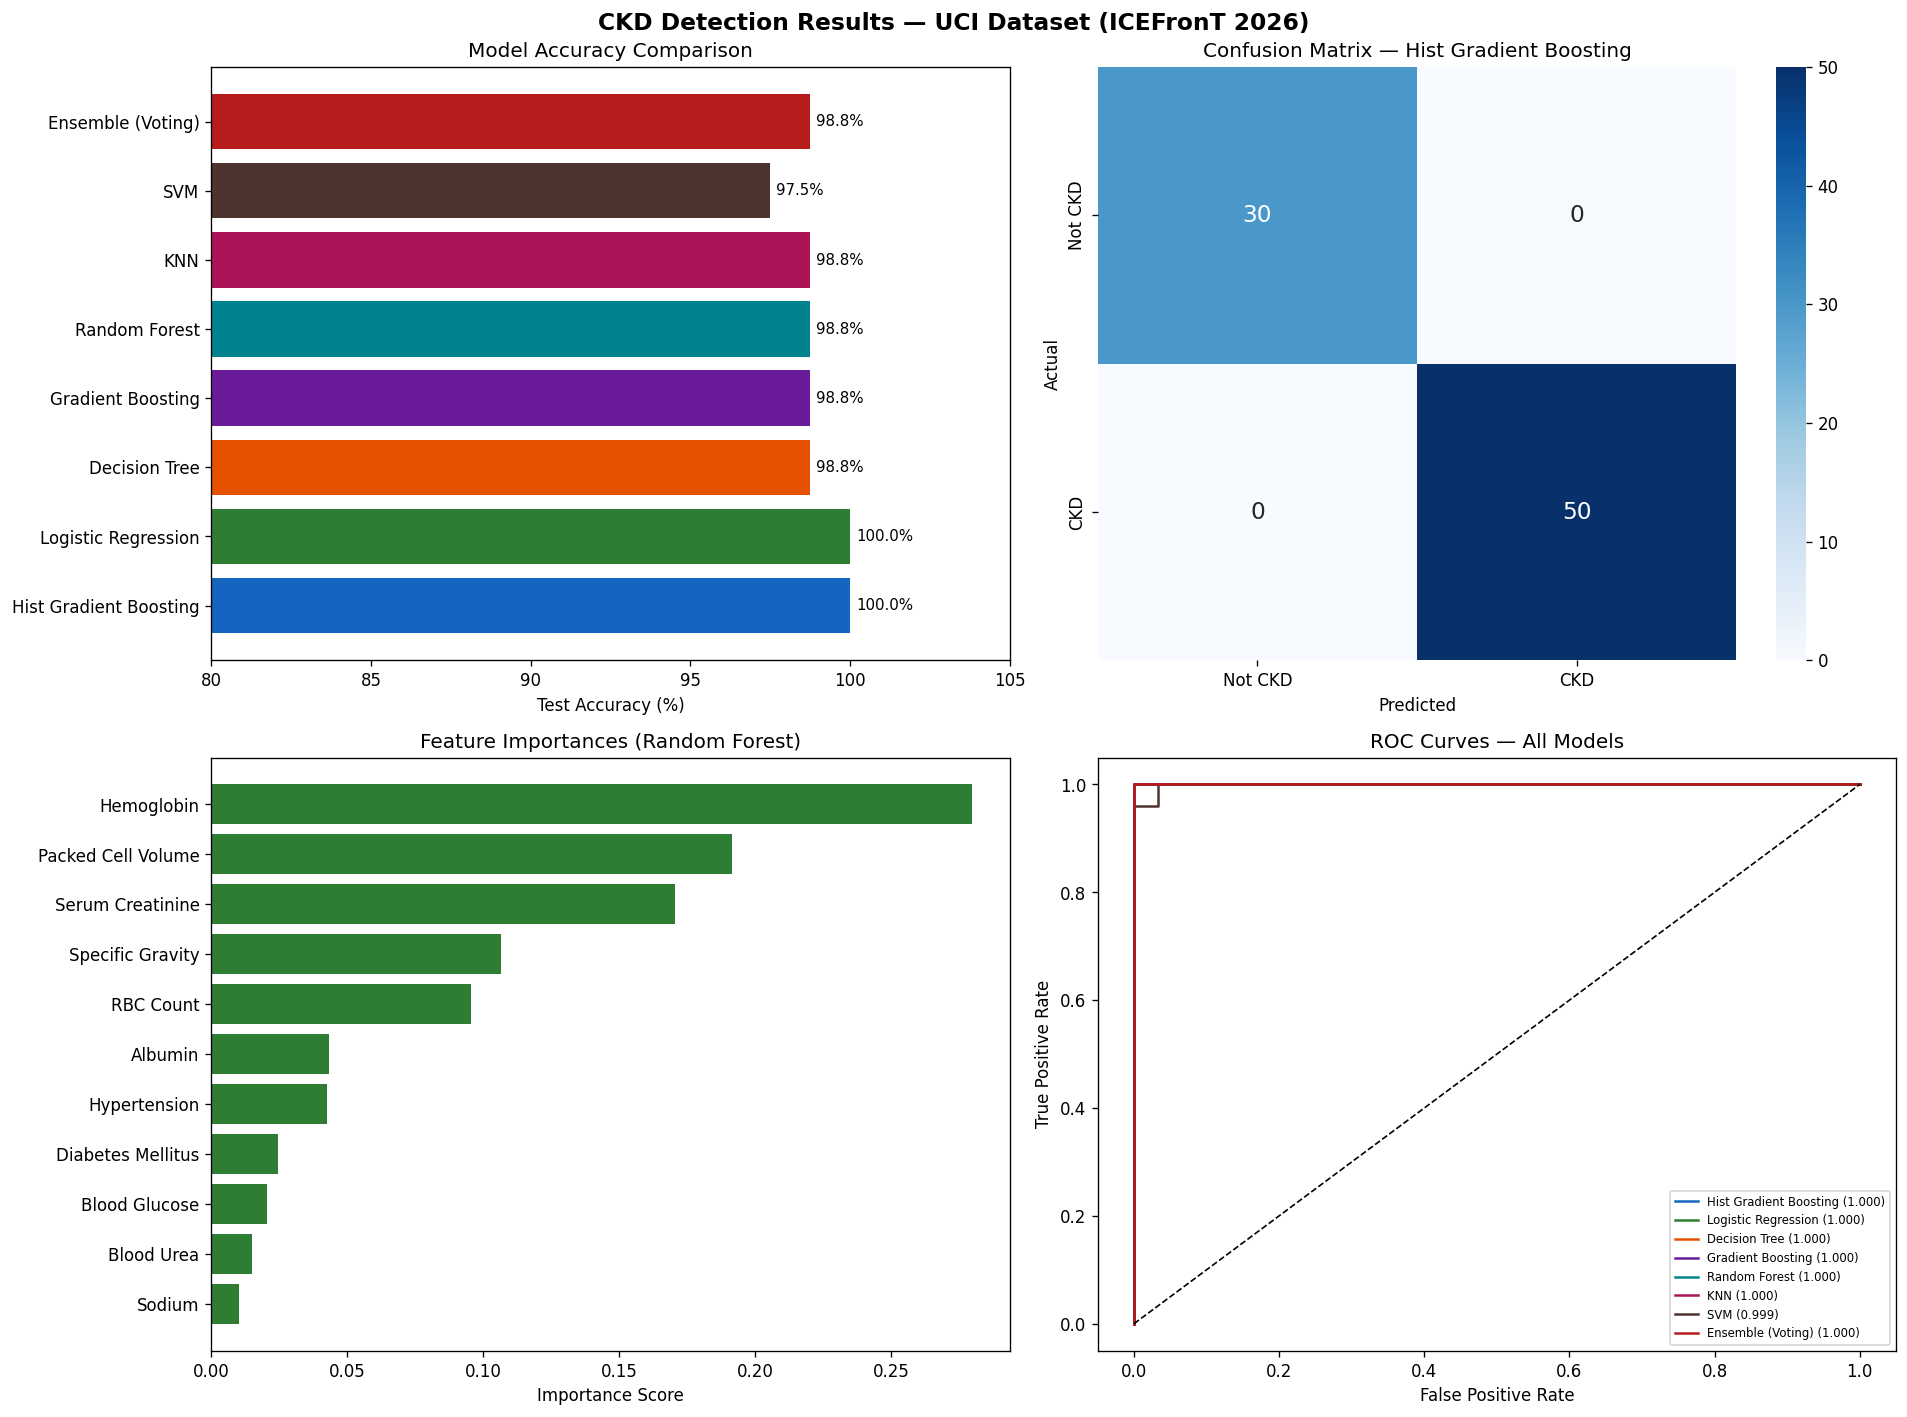

Results plot saved ✅


In [53]:
# ============================================================
# 8. RESULTS VISUALIZATION
# ============================================================
best_name = results_df.iloc[0]['Model']
_, y_pred_best, y_prob_best = trained[best_name]

PAL = ['#1565C0','#2E7D32','#E65100','#6A1B9A','#00838F','#AD1457','#4E342E']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('CKD Detection Results — UCI Dataset (ICEFronT 2026)',
             fontsize=14, fontweight='bold')

# Plot 1: Accuracy comparison
ax1 = axes[0, 0]
all_names = list(results_df['Model']) + ['Ensemble (Voting)']
all_acc   = list(results_df['Test Acc (%)']) + [round(ens_acc*100, 2)]
bars = ax1.barh(all_names, all_acc, color=PAL + ['#B71C1C'])
ax1.set_xlabel('Test Accuracy (%)')
ax1.set_title('Model Accuracy Comparison')
ax1.set_xlim([80, 105])
for bar, val in zip(bars, all_acc):
    ax1.text(bar.get_width()+0.2, bar.get_y()+bar.get_height()/2,
             f'{val:.1f}%', va='center', fontsize=9)

# Plot 2: Confusion Matrix
ax2 = axes[0, 1]
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['Not CKD','CKD'],
            yticklabels=['Not CKD','CKD'],
            annot_kws={'size':14})
ax2.set_title(f'Confusion Matrix — {best_name}')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

# Plot 3: Feature Importance (RF)
ax3 = axes[1, 0]
rf_model = trained['Random Forest'][0]
feat_imp = (pd.DataFrame({'Feature': SELECTED_FEATURES,
                           'Importance': rf_model.feature_importances_})
            .sort_values('Importance', ascending=True))
feat_imp['FullName'] = feat_imp['Feature'].map(FEAT_NAMES)
ax3.barh(feat_imp['FullName'], feat_imp['Importance'], color='#2E7D32')
ax3.set_title('Feature Importances (Random Forest)')
ax3.set_xlabel('Importance Score')

# Plot 4: ROC Curves
ax4 = axes[1, 1]
for nm, color in zip(list(results_df['Model']) + ['Ensemble (Voting)'],
                     PAL + ['#B71C1C']):
    prob = trained[nm][2] if nm != 'Ensemble (Voting)' else y_prob_ens
    fpr, tpr, _ = roc_curve(y_test, prob)
    auc_v = roc_auc_score(y_test, prob)
    ax4.plot(fpr, tpr, color=color, lw=1.5, label=f'{nm} ({auc_v:.3f})')
ax4.plot([0,1],[0,1],'k--', lw=1)
ax4.set_xlabel('False Positive Rate')
ax4.set_ylabel('True Positive Rate')
ax4.set_title('ROC Curves — All Models')
ax4.legend(fontsize=7, loc='lower right')

plt.tight_layout()
plt.savefig('ckd_results.png', dpi=150, bbox_inches='tight')
plt.show()
print('Results plot saved ✅')

In [54]:
# ============================================================
# 9. SHAP EXPLAINABILITY — Random Forest
# ============================================================
print('Computing SHAP values... (may take ~30 seconds)')

rf_for_shap = trained['Random Forest'][0]

# TreeExplainer — fastest for tree-based models
explainer = shap.TreeExplainer(rf_for_shap)
shap_values = explainer.shap_values(X_test)

# shap_values shape for binary TreeExplainer on multi-output model is (n_samples, n_features, n_classes)
# We need to select the SHAP values for the positive class (CKD), which is class 1.
# This means taking the slice `[:, :, 1]` from the shap_values array.
if isinstance(shap_values, list): # This path is for old SHAP versions or certain explainers
    shap_ckd = shap_values[1]  # class 1 = CKD
else: # This path is for new SHAP versions or TreeExplainer returning (samples, features, classes)
    shap_ckd = shap_values[:, :, 1] # Select SHAP values for class 1 (CKD)

feat_display_names = [FEAT_NAMES.get(f, f) for f in SELECTED_FEATURES]
X_test_df = pd.DataFrame(X_test, columns=feat_display_names)

print('SHAP values computed ✅')
print(f'SHAP array shape: {shap_ckd.shape}')

Computing SHAP values... (may take ~30 seconds)
SHAP values computed ✅
SHAP array shape: (80, 11)


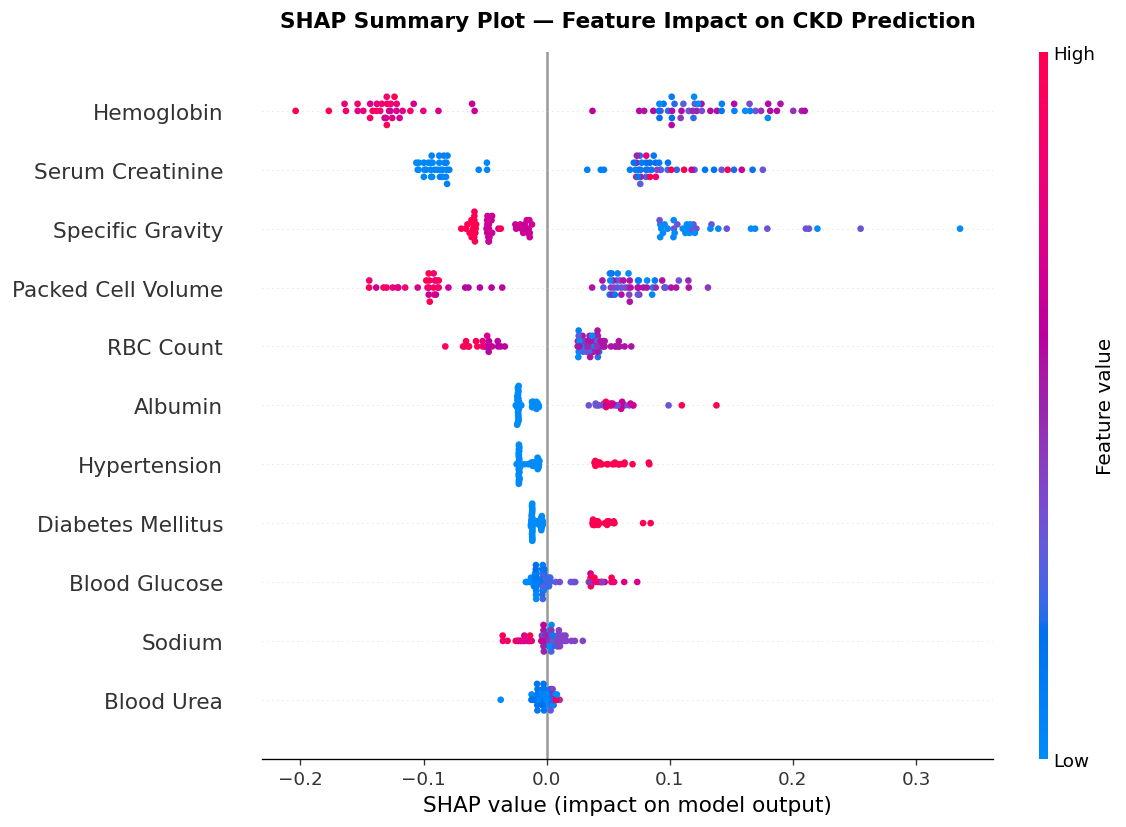

SHAP summary plot saved ✅


In [55]:

# ── SHAP Plot 1: Summary Beeswarm ─────────────────────────────
# Shows: which features matter most AND how they affect prediction
# Red = high feature value, Blue = low feature value
# Right side = pushes toward CKD, Left = pushes toward NotCKD

plt.figure(figsize=(10, 7))
shap.summary_plot(shap_ckd, X_test_df,
                  feature_names=feat_display_names,
                  show=False, plot_size=None)
plt.title('SHAP Summary Plot — Feature Impact on CKD Prediction',
          fontsize=13, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig('shap_summary.png', dpi=150, bbox_inches='tight')
plt.show()
print('SHAP summary plot saved ✅')

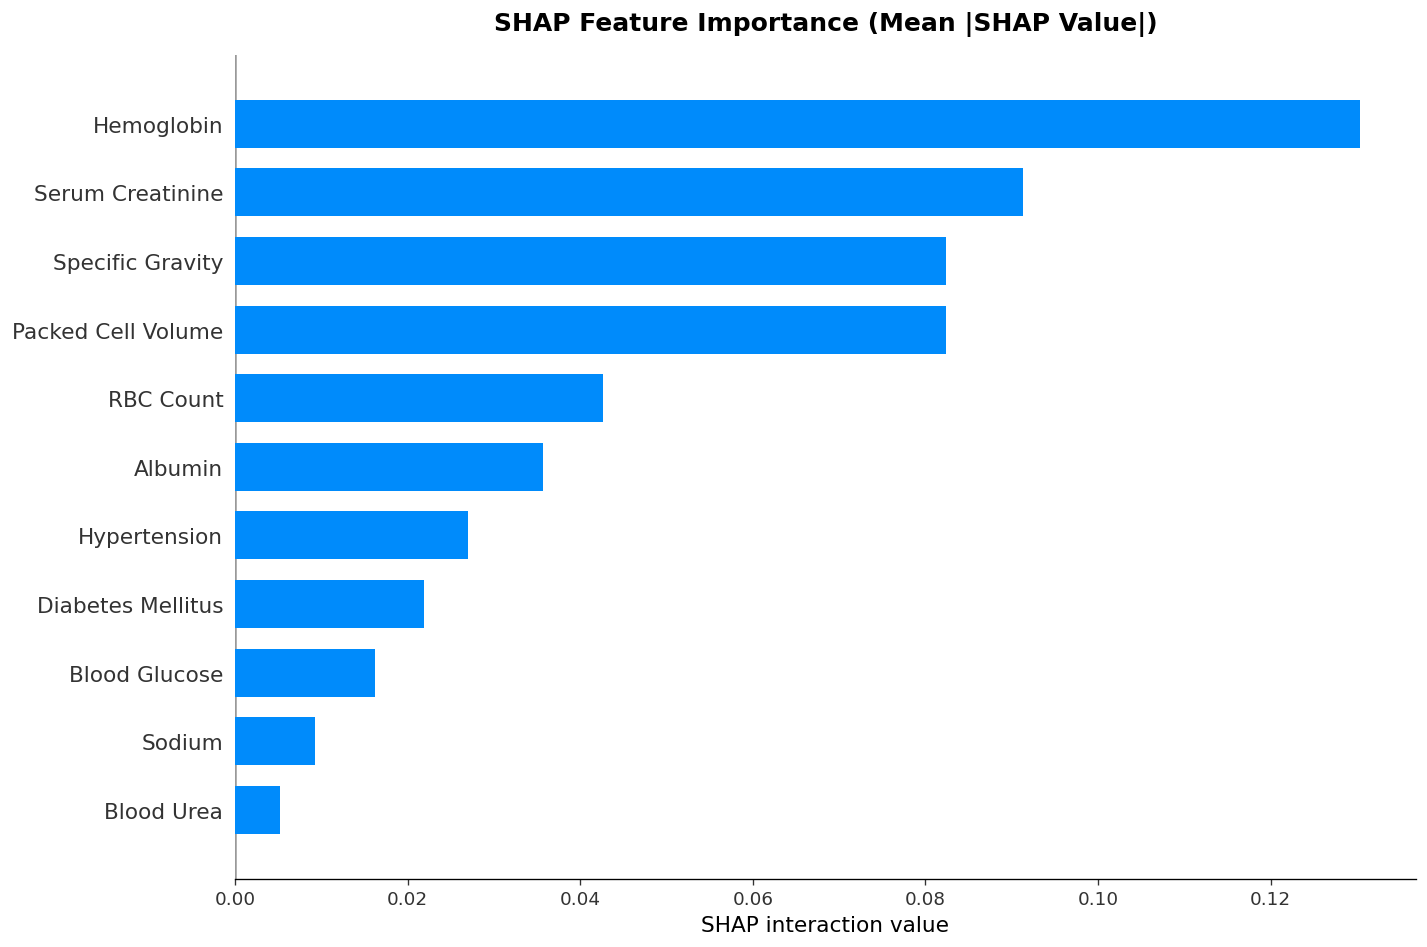

SHAP bar plot saved ✅


In [56]:
# ── SHAP Plot 2: Bar Plot (mean |SHAP|) ────────────────────────
plt.figure(figsize=(12, 8))

shap.summary_plot(shap_ckd, X_test_df,
                  feature_names=feat_display_names,
                  plot_type='bar', show=False, plot_size=None)

fig = plt.gcf()
axes = fig.get_axes()
main_ax = axes[0]

# ── Remove stray "Albumin" text drawn by SHAP ─────────────────
for txt in fig.texts:
    txt.set_visible(False)

for txt in main_ax.texts:
    txt.set_visible(False)

# ── Title ─────────────────────────────────────────────────────
main_ax.set_title('SHAP Feature Importance (Mean |SHAP Value|)',
                  fontsize=15, fontweight='bold', pad=15)

# ── Axis labels ───────────────────────────────────────────────
main_ax.set_xlabel('SHAP interaction value', fontsize=13)

# ── Tick sizes ────────────────────────────────────────────────
main_ax.tick_params(axis='y', labelsize=13)
main_ax.tick_params(axis='x', labelsize=11)

# ── Colorbar fix (if present) ─────────────────────────────────
if len(axes) > 1:
    cbar_ax = axes[1]
    cbar_ax.set_ylabel('Feature value', fontsize=12, labelpad=10)
    cbar_ax.tick_params(labelsize=10)
    for txt in cbar_ax.texts:
        txt.set_visible(False)

plt.tight_layout()
plt.savefig('shap_bar.png', dpi=150, bbox_inches='tight')
plt.show()
print('SHAP bar plot saved ✅')

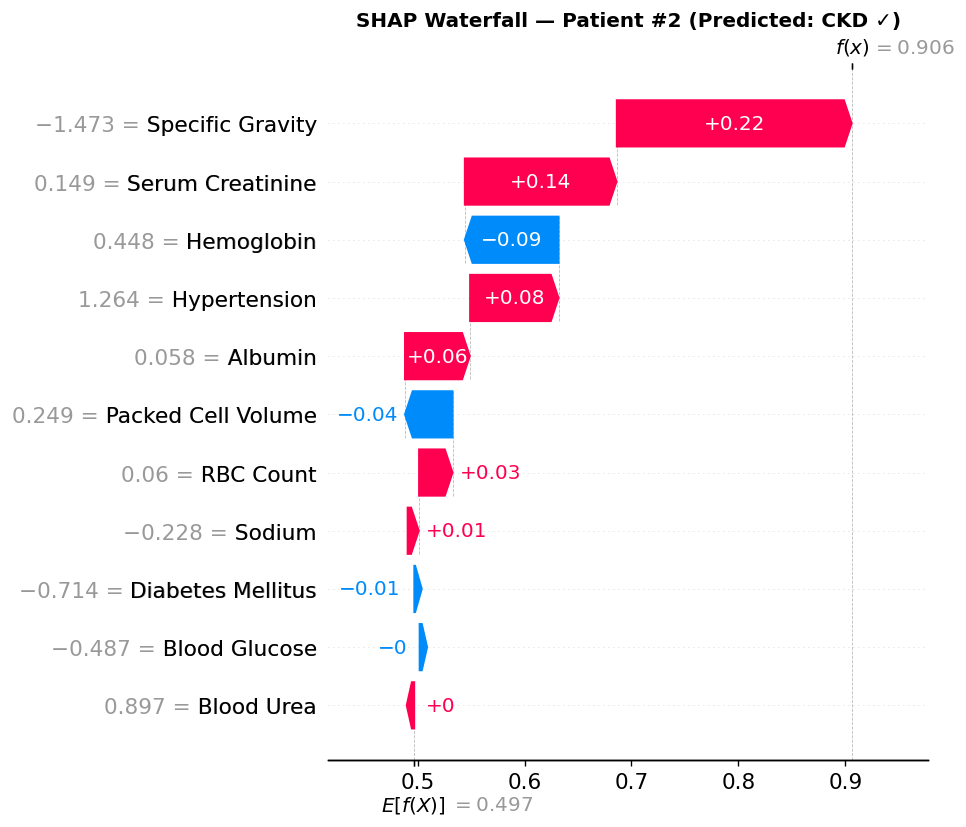

Waterfall plot saved — Patient #2 explanation ✅


In [57]:
# ── SHAP Plot 3: Waterfall — Single Patient Explanation ────────
# Explains ONE specific prediction in detail
# Perfect for clinical interpretation in paper

# Find a correctly predicted CKD patient
ckd_indices = np.where((y_test == 1) & (trained['Random Forest'][1] == 1))[0]
patient_idx = ckd_indices[0]

# Re-compute using explainer() call — returns proper Explanation object
# For binary RF, values shape is (n_samples, n_features, 2) — take CKD class (index 1)
shap_vals_obj = explainer(X_test_df)

if len(shap_vals_obj.values.shape) == 3:
    # Multi-output: slice class 1 (CKD)
    single_exp = shap.Explanation(
        values       = shap_vals_obj.values[patient_idx, :, 1],
        base_values  = shap_vals_obj.base_values[patient_idx, 1],
        data         = shap_vals_obj.data[patient_idx],
        feature_names= feat_display_names
    )
else:
    # Single output
    single_exp = shap.Explanation(
        values       = shap_vals_obj.values[patient_idx],
        base_values  = float(shap_vals_obj.base_values[patient_idx]),
        data         = shap_vals_obj.data[patient_idx],
        feature_names= feat_display_names
    )

plt.figure(figsize=(10, 6))
shap.plots.waterfall(single_exp, max_display=12, show=False)
plt.title(f'SHAP Waterfall — Patient #{patient_idx+1} (Predicted: CKD ✓)',
          fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('shap_waterfall.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'Waterfall plot saved — Patient #{patient_idx+1} explanation ✅')

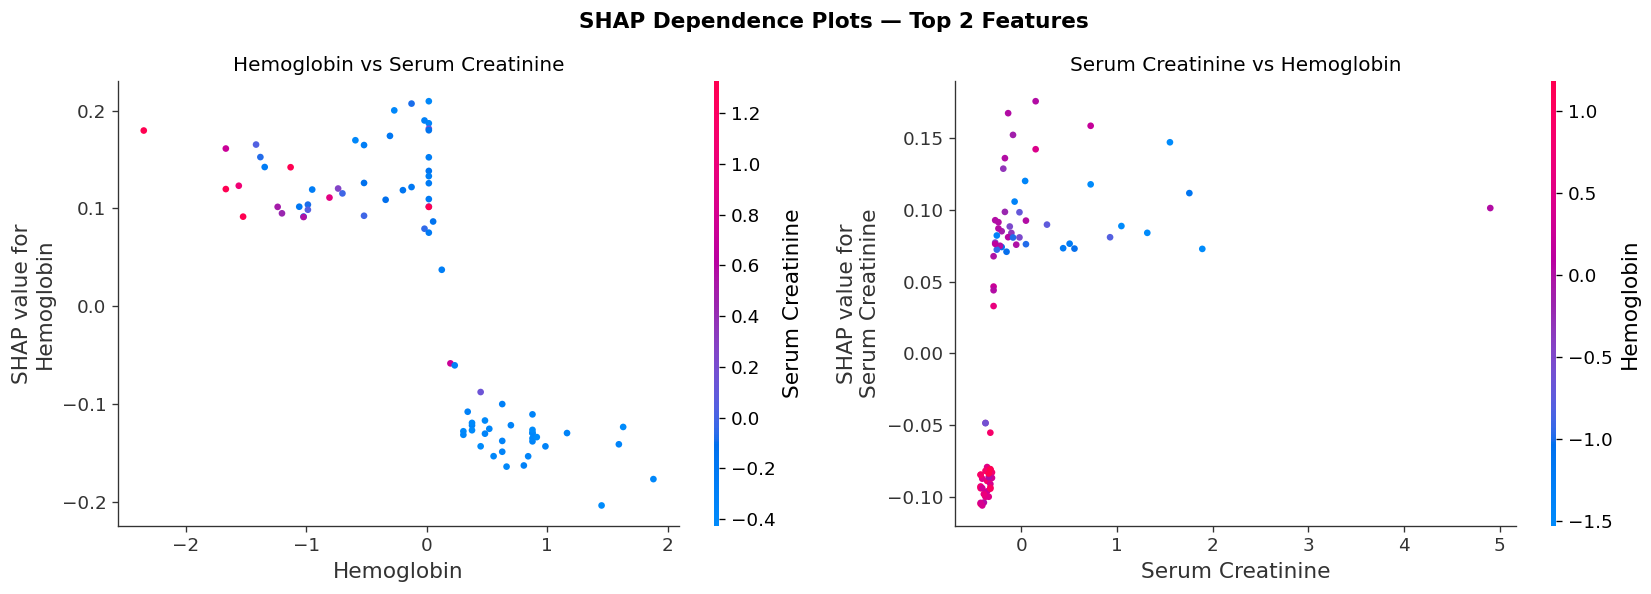

Dependence plot saved ✅


In [58]:
# ── SHAP Plot 4: Dependence Plot — Top 2 Features ──────────────
# Shows how top feature interacts with second feature

mean_shap = np.abs(shap_ckd).mean(axis=0)
top_feat_idx = np.argsort(mean_shap)[::-1]
top1 = feat_display_names[top_feat_idx[0]]
top2 = feat_display_names[top_feat_idx[1]]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('SHAP Dependence Plots — Top 2 Features', fontsize=13, fontweight='bold')

shap.dependence_plot(top1, shap_ckd, X_test_df,
                     interaction_index=top2, ax=axes[0], show=False)
axes[0].set_title(f'{top1} vs {top2}')

shap.dependence_plot(top2, shap_ckd, X_test_df,
                     interaction_index=top1, ax=axes[1], show=False)
axes[1].set_title(f'{top2} vs {top1}')

plt.tight_layout()
plt.savefig('shap_dependence.png', dpi=150, bbox_inches='tight')
plt.show()
print('Dependence plot saved ✅')

In [59]:
# ============================================================
# 10. FINAL PAPER-READY SUMMARY
# ============================================================
print('=' * 65)
print('PAPER-READY SUMMARY — ICEFronT 2026')
print('=' * 65)

print(f'\n📌 Dataset: UCI CKD | {len(df)} samples | {X_raw.shape[1]} features')
print(f'📌 After Feature Selection: {len(SELECTED_FEATURES)} features selected')
print(f'   Selected: {[FEAT_NAMES.get(f,f) for f in SELECTED_FEATURES]}')

print(f'\n📊 BEST MODEL: {results_df.iloc[0]["Model"]}')
print(f'   Accuracy  : {results_df.iloc[0]["Test Acc (%)"]:.2f}%')
print(f'   Precision : {results_df.iloc[0]["Precision (%)"]:.2f}%')
print(f'   Recall    : {results_df.iloc[0]["Recall (%)"]:.2f}%')
print(f'   F1-Score  : {results_df.iloc[0]["F1-Score (%)"]:.2f}%')
print(f'   AUC-ROC   : {results_df.iloc[0]["AUC-ROC (%)"]:.2f}%')

print(f'\n🗳️  ENSEMBLE (Soft Voting):')
print(f'   Accuracy  : {ens_acc*100:.2f}%')
print(f'   F1-Score  : {ens_f1*100:.2f}%')
print(f'   AUC-ROC   : {ens_auc*100:.2f}%')

# Top SHAP features
mean_shap_imp = pd.Series(np.abs(shap_ckd).mean(axis=0),
                           index=[FEAT_NAMES.get(f,f) for f in SELECTED_FEATURES])
mean_shap_imp = mean_shap_imp.sort_values(ascending=False)
print(f'\n🔍 TOP SHAP FEATURES (Clinical Insights):')
for feat, val in mean_shap_imp.head(5).items():
    print(f'   {feat:<30}: {val:.4f}')

print(f'\n📁 Files generated:')
print(f'   feature_selection.png — for Section III')
print(f'   ckd_results.png       — for Section IV (Results)')
print(f'   shap_summary.png      — for Section V (Explainability)')
print(f'   shap_bar.png          — for Section V')
print(f'   shap_waterfall.png    — for Section V (Case Study)')
print(f'   shap_dependence.png   — for Section V')

print('\n' + '=' * 65)
print('COMPLETE ✅  All results are publication-ready')
print('=' * 65)

PAPER-READY SUMMARY — ICEFronT 2026

📌 Dataset: UCI CKD | 397 samples | 24 features
📌 After Feature Selection: 11 features selected
   Selected: ['Albumin', 'Specific Gravity', 'Diabetes Mellitus', 'Blood Glucose', 'Hypertension', 'Blood Urea', 'Hemoglobin', 'Packed Cell Volume', 'RBC Count', 'Sodium', 'Serum Creatinine']

📊 BEST MODEL: Hist Gradient Boosting
   Accuracy  : 100.00%
   Precision : 100.00%
   Recall    : 100.00%
   F1-Score  : 100.00%
   AUC-ROC   : 100.00%

🗳️  ENSEMBLE (Soft Voting):
   Accuracy  : 98.75%
   F1-Score  : 99.01%
   AUC-ROC   : 100.00%

🔍 TOP SHAP FEATURES (Clinical Insights):
   Hemoglobin                    : 0.1303
   Serum Creatinine              : 0.0913
   Specific Gravity              : 0.0823
   Packed Cell Volume            : 0.0823
   RBC Count                     : 0.0427

📁 Files generated:
   feature_selection.png — for Section III
   ckd_results.png       — for Section IV (Results)
   shap_summary.png      — for Section V (Explainability)
  